<a href="https://colab.research.google.com/github/Teodil/dataAnaliz/blob/main/mnist_convolut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from matplotlib import pyplot

import cv2

In [ ]:
(xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.fashion_mnist.load_data()

**Преобразуем цифровые метки классов в бинарные категории one-hot encoding**

In [ ]:
ytrain_t = tf.keras.utils.to_categorical(ytrain)
ytest_t = tf.keras.utils.to_categorical(ytest)

**Входные данные (обучающие и тестовые) в виде интенсивности цветов также нужно преобразовать:**
1. **Исходный массив нужно преобразовать к 4-мерному тензору функцией reshape: (объем выборки, высота, ширина, кол-во цветовых каналов). По-хорошему, следует извлекать эти данные из масива типа len(xtrain), xtrain[0].shape и т.д., но в данном случае мы знаем структуру данных.**
2. **Нужно нормировать интенсивности, преобразовав к типу float32, а затем разделив на максимальную интенсивность - 255 (если не преобразовать к дробному типу, то не получится разделить)**

In [ ]:
xtrain_t = tf.reshape(xtrain, (60000, 28, 28, 1))
xtrain_t = tf.cast(xtrain_t, tf.float32) / 255.0

xtest_t = tf.reshape(xtest, (10000, 28, 28, 1))
xtest_t = tf.cast(xtest_t, tf.float32) / 255.0


NameError: ignored

Вся основная магия - в структуре модели.
Добавляем новые типы слоев: сверточный и пулинг (обычно их используют такими парами). Здесь на функциях свертки и пулинга я останавливаться не буду - посмотрите отдельно. Важно обратить внимание на параметры.
1. Сверточный слой. Кол-во ядер свертки filters (фильтров, содержащих характерные свойства элементов изображений), размер этих матриц свертки (kernel): часто используют (3x3). Попробуйте поменять их размер на (5,5). параметр input_shape определяет размер входного тензора - размеры картинки: 28x28 пикселей с одним цветовым каналом (интенсивность серого). Есть еще параметр padding - используется бля прохода центра свертки по краю картинки (посмотрите информацию в теории). Попробуйте его тоже применить.
2. Пулинг - обычно используется матрица 2x2 для выбора максимального значения.
3. Абстрактный слой Flatten, который просто разворачивает танзоры в линию и связывает с полносвязным классификатором Dense.  

Попробуйте более одного слоя свертки (осторожно: сильно падает скорость обучения!)

In [ ]:
model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', input_shape = (28,28,1)),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
      #tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
      #tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units = 320, activation = 'relu'),
      tf.keras.layers.Dense(units = 10, activation = 'softmax')
])

**Попробуйте также разные параметры обучения:**

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

**Поразиться количеству настраиваемых параметров модели:**

In [ ]:
model.summary()

**Не стоит задавать много эпох. Даже на 4-х эпохах можно пойти попить чай**

In [ ]:
hist = model.fit(xtrain_t, ytrain_t, batch_size = 128, epochs=4)

Epoch 1/4
469/469 [==============================] - 68s 145ms/step - loss: 0.4292 - accuracy: 0.8462
Epoch 2/4
469/469 [==============================] - 65s 139ms/step - loss: 0.2862 - accuracy: 0.8956
Epoch 3/4
469/469 [==============================] - 65s 138ms/step - loss: 0.2421 - accuracy: 0.9114
Epoch 4/4
469/469 [==============================] - 65s 138ms/step - loss: 0.2093 - accuracy: 0.9223


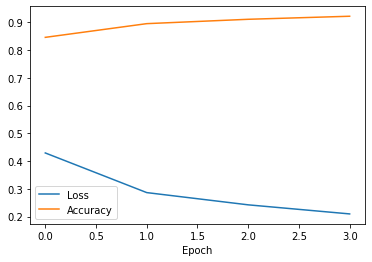

In [ ]:
pyplot.plot(hist.history['loss'])
pyplot.plot(hist.history['accuracy'])
pyplot.xlabel('Epoch')
pyplot.legend(['Loss', 'Accuracy'])
pyplot.show()

In [ ]:
test_loss, test_acc = model.evaluate(xtest_t, ytest_t)
print("loss:", test_loss, "; accuracy:", test_acc)

313/313 [==============================] - 4s 12ms/step - loss: 0.2683 - accuracy: 0.9003
loss: 0.2683320939540863 ; accuracy: 0.9003000259399414


**Согласно различным источникам в интернете, данный датасет является "challenging" и добиться 100% качества обучения не удавалось: обычно это от 90 до 95%. Некоторые изображения даже визуально трудно классифицировать. Низкое качество изображений и их деталей: свитер легко спутать с рубашкой**
**Подбирать оптимальную настройку параетров сети - занятие довольно затратное по времени.**

Проведем тесты вручную, посмотрим отдельные экземпляры гарбероба:

In [ ]:
y_pred = model.predict(xtest_t)


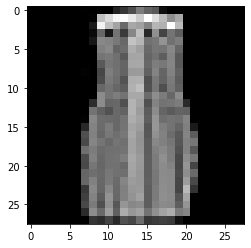

In [ ]:
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

test_index = 9235
pyplot.imshow(xtest[test_index], cmap='gray')


In [ ]:
pred_val = np.argmax( y_pred[test_index])
real_val = ytest[test_index]
print("Нейросеть считает:", labels[pred_val], "\nНа самом деле:", labels[real_val])

Нейросеть считает: Coat 
На самом деле: Dress


In [ ]:
y_cat = np.argmax(y_pred, axis = 1)
errCount = 0
for i in range(len(y_cat)):
  if y_cat[i] != ytest[i]:
    print("Тест №", i, "провален")
    errCount += 1
print(errCount, "из", len(y_cat), "неверных ответов")

**Посмотрим, как работает обученная нейросеть с произвольными картинками из интернета.** 

Важно помнить, что сеть ориентирована только на один цветовой канал - градации серого. Поэтому придется их преобразовывать и сжимать до формата входного тензора сети, т.е. (28 ширина, 28 высота, 1 канал).

Для предобработки используем биб-ку OpenCV - cv2 - библиотека машинного зрения, которая включает в себя много полезных функций рутиной предобработки изображений. Ее не нужно устанавливать - в collab она уже встроена!

**Как сюда загружать картинки?**
* Можно тянуть прямо по гиперссылке из интернета, но там больше действий. Если так хотите, то ищите код сами.
* Картинки можно загрузить в рабочее пространство, но **только на время текущей сессии**! В данном ноутбуке именно такой способ. Слева есть пиктограмма папки: жмите ее, откроется фрем "Файлы" (корневая папка, sample_data). Жмете правой кнопкой - меню "Загрузить". ВЫбираете с диска файлы и загружаете.
* Можете открыть доступ к данным своего google-диска.

После загрузки узнать путь к этому файлу можно правой кнопкой по нему.

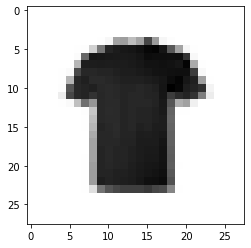

In [ ]:
#загружаем картинку
img = cv2.imread('/content/sample_data/tshirt02.jpg')

#преобразуем к градациям серого
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY )

#интересный момент предобработи! для накоторых произвольных картинок
#нужно добавить пространство вокруг (рамку). Величина этой рамки, понятно, зависит
#от размеров картинки, и лучше добавлять в процентном соотношении, но для обычно используемых
#изображений в сотни пикселей - достаточно 50 (особенно это хорошо видно на штанах trouser02.jpg)
#а для некоторых картинок она не нужна. т.е. имеет место еще немалая работа по подготовке качественных картинок
gray = cv2.copyMakeBorder(gray, 50, 50, 50, 50, cv2.BORDER_CONSTANT, None, value = 255)

#уменьшаем картинку до размеров 28x28 пикселей
resized = cv2.resize(gray, (28,28), interpolation = cv2.INTER_AREA)
#посмотрим, что там получилось
pyplot.imshow(resized , cmap='gray')
pyplot.show()

Готовим данные картинки непосредственно для ввода в нейросеть - интенсивности пикселей нужно отформатировать под входной 4-мерный тензор (1 пример, 28 пикс, 28 пикс, 1 канал), далее, как и при обучении нужно нормировать, преобразовав числа во float (если не преобразовать, то не получится разделить на 255)

**Важный момент!**
Мы обучали картинки на черном фоне - т.е. фон никаких сигналов не посылал. В данных примерах фон фонит на полную интенсивность. Это не есть хорошо. По-хорошему его надо перекрасить, но мы для простоты просто инвертируем цвета: (1.0 - color)

In [ ]:
pred_image = tf.reshape(resized,(1,28,28,1))
pred_image = tf.cast(pred_image, tf.float32)
pred_image = 1.0 - pred_image / 255.0

#делаем predict для одного примера, получаем сигналы выходов
image_pred = model.predict(pred_image)

#смотрим, какой сигнал "громче" всех и выбираем соответствующую метку:
#print(image_pred)
print(labels[ np.argmax(image_pred) ])

T-shirt/top
